# Imports

In [1]:
import random

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from IPython.display import display
from torch.utils.data import DataLoader, TensorDataset
import ipywidgets as widgets

In [2]:
# helper functions
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis(False)
    plt.show()


def plot_function_approximation(x, relu_acts, y_hat):
    fig, axes = plt.subplots(2, 1)

    # Plot ReLU Activations
    axes[0].plot(x, relu_acts.T);
    axes[0].set(xlabel='x',
              ylabel='Activation',
              title='ReLU Activations - Basis Functions')
    labels = [f"ReLU {i + 1}" for i in range(relu_acts.shape[0])]
    axes[0].legend(labels, ncol = 2)

    # Plot function approximation
    axes[1].plot(x, torch.sin(x), label='truth')
    axes[1].plot(x, y_hat, label='estimated')
    axes[1].legend()
    axes[1].set(xlabel='x',
              ylabel='y(x)',
              title='Function Approximation')

    plt.tight_layout()
    plt.show()
    
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return device

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')
    
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


# Biological vs. Artificial Neural Networks

## Universal Approximation Theorem

Based on the UAT, we know that one hidden layer MLPs are enough to approximate any smooth function! Now let's manually fit a sine function using ReLU activation. 

We will approximate the sine function using a linear combination (a weighted sum) of ReLUs with slope 1. We need to determine the bias terms (which determines where the ReLU inflection point from 0 to linear occurs) and how to weight each ReLU. The idea is to set the weights iteratively so that the slope changes in the new sample's direction.

First, we generate our "training data" from a sine function using `torch.sine` function.

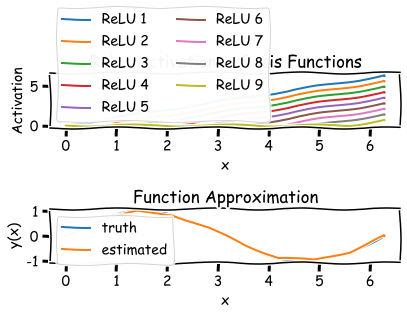

In [3]:
def approximate_function(x_train, y_train):

    # Number of relus
    n_relus = x_train.shape[0] - 1

    # x axis points (more than x train)
    x = torch.linspace(torch.min(x_train), torch.max(x_train), 1000)

    ## COMPUTE RELU ACTIVATIONS

    # First determine what bias terms should be for each of `n_relus` ReLUs
    b = -x_train[:-1]

    # Compute ReLU activations for each point along the x axis (x)
    relu_acts = torch.zeros((n_relus, x.shape[0]))

    for i_relu in range(n_relus):
        relu_acts[i_relu, :] = torch.relu(x + b[i_relu])

    ## COMBINE RELU ACTIVATIONS

    # Set up weights for weighted sum of ReLUs
    combination_weights = torch.zeros((n_relus, ))

    # Figure out weights on each ReLU
    prev_slope = 0
    for i in range(n_relus):
        delta_x = x_train[i+1] - x_train[i]
        slope = (y_train[i+1] - y_train[i]) / delta_x
        combination_weights[i] = slope - prev_slope
        prev_slope = slope

    # Get output of weighted sum of ReLU activations for every point along x axis
    y_hat = combination_weights @ relu_acts

    return y_hat, relu_acts, x

# Make training data from sine function
N_train = 10
x_train = torch.linspace(0, 2*np.pi, N_train).view(-1, 1)
y_train = torch.sin(x_train)

y_hat, relu_acts, x = approximate_function(x_train, y_train)
with plt.xkcd():
    plot_function_approximation(x, relu_acts, y_hat)

## MLPs in PyTorch

The objective is to design an MLP with these properties:
* works with any input (1D, 2D, etc.)
* construct any number of given hidden layers using `nn.Sequential()` and `add_module()` function
* use the same given activation function (i.e., [Leaky ReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html)) in all hidden layers.

**Leaky ReLU** is described by the following mathematical formula:

\begin{equation}
\text{LeakyReLU}(x) = \text{max}(0,x) + \text{negative_slope} \cdot \text{min}(0, x) =
\left\{
  \begin{array}{ll}
  x & ,\; \text{if} \; x \ge 0 \\
  \text{negative_slope} \cdot x & ,\;  \text{otherwise}
  \end{array}
\right.
\end{equation}

In [4]:
class Net(nn.Module):
    def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
        super(Net, self).__init__()
        self.input_feature_num = input_feature_num # save the input size for reshapinng later
        self.mlp = nn.Sequential() # Initialize layers of MLP

        in_num = input_feature_num # initialize the temporary input feature to each layer
        for i in range(len(hidden_unit_nums)): # Loop over layers and create each one
            out_num = hidden_unit_nums[i] # assign the current layer hidden unit from list
            layer = nn.Linear(in_num, out_num) # use nn.Linear to define the layer
            in_num = out_num # assign next layer input using current layer output
            self.mlp.add_module('Linear_%d'%i, layer) # append layer to the model with a name

            actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
            self.mlp.add_module('Activation_%d'%i, actv_layer) # append activation to the model with a name

        out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
        self.mlp.add_module('Output_Linear', out_layer) # append the final layer

    def forward(self, x):
        # reshape inputs to (batch_size, input_feature_num)
        # just in case the input vector is not 2D, like an image!
        x = x.view(-1, self.input_feature_num)
        logits = self.mlp(x) # forward pass of MLP
        return logits
    
DEVICE = set_device()
input = torch.zeros((100, 2))
net = Net(actv='LeakyReLU(0.1)', input_feature_num=2, hidden_unit_nums=[100, 10, 5], output_feature_num=1).to(DEVICE)
y = net(input.to(DEVICE))
print(f'The output shape is {y.shape} for an input of shape {input.shape}')

The output shape is torch.Size([100, 1]) for an input of shape torch.Size([100, 2])


## Classification with MLPs

The main loss function we could use out of the box for multi-class classification for `N` samples and `C` number of classes is:
* CrossEntropyLoss:
This criterion expects a batch of predictions `x` with shape `(N, C)` and class index in the range $[0, C-1]$ as the target (label) for each `N` samples, hence a batch of `labels` with shape `(N, )`. There are other optional parameters like class weights and class ignores. Feel free to check the PyTorch documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) for more detail. Additionally, [here](https://sparrow.dev/cross-entropy-loss-in-pytorch/) you can learn where is appropriate to use the CrossEntropyLoss.

To get CrossEntropyLoss of a sample $i$, we could first calculate $-\log(\text{softmax(x}))$ and then take the element corresponding to $\text { labels }_i$ as the loss. However, due to numerical stability, we implement this more stable equivalent form,

\begin{equation}
\operatorname{loss}(x_i, \text { labels }_i)=-\log \left(\frac{\exp (x[\text { labels }_i])}{\sum_{j} \exp (x[j])}\right)=-x_i[\text { labels }_i]+\log \left(\sum_{j=1}^C \exp (x_i[j])\right)
\end{equation}

To recap, since we will be doing batch learning, we'd like a loss function that given:
* a batch of predictions `x` with shape `(N, C)` 
* a batch of `labels` with shape `(N, )` that ranges from `0` to `C-1`

returns the average loss $L$ calculated according to:

\begin{align}
loss(x_i, \text { labels }_i) &= -x_i[\text { labels }_i]+\log \left(\sum_{j=1}^C \exp (x_i[j])\right) \\
L &= \frac{1}{N} \sum_{i=1}^{N}{loss(x_i, \text { labels }_i)}
\end{align}

Steps:

1.   Use indexing operation to get predictions of class corresponding to the labels (i.e., $x_i[\text { labels }_i]$)
2.   Compute $loss(x_i, \text { labels }_i)$ vector (`losses`) using `torch.log()` and `torch.exp()` without Loops!
3. Return the average of the loss vector

In [5]:
def cross_entropy_loss(x, labels):
    # x is the model predictions we'd like to evaluate using lables
    x_of_labels = torch.zeros(len(labels))
    # 1. prediction for each class corresponding to the label
    for i, label in enumerate(labels):
        x_of_labels[i] = x[i, label]
    # 2. loss vector for the batch
    losses = -x_of_labels + torch.log(torch.sum(torch.exp(x), axis=1))
    # 3. Return the average of the loss vector
    avg_loss = losses.mean()

    return avg_loss

labels = torch.tensor([0, 1])
x = torch.tensor([[10.0, 1.0, -1.0, -20.0],  # correctly classified
                  [10.0, 10.0, 2.0, -10.0]])  # Not correctly classified
CE = nn.CrossEntropyLoss()
pytorch_loss = CE(x, labels).item()
our_loss = cross_entropy_loss(x, labels).item()
print(f'Our CE loss: {our_loss:0.8f}, Pytorch CE loss: {pytorch_loss:0.8f}')
print(f'Difference: {np.abs(our_loss - pytorch_loss):0.8f}')

Our CE loss: 0.34672737, Pytorch CE loss: 0.34672749
Difference: 0.00000012


## Training and Evaluation

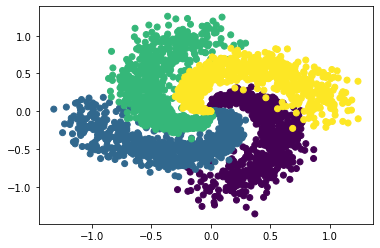

In [6]:
# create spiral dataset
def create_spiral_dataset(K, sigma, N):

    # Initialize t, X, y
    t = torch.linspace(0, 1, N)
    X = torch.zeros(K*N, 2)
    y = torch.zeros(K*N)

    # Create data
    for k in range(K):
        X[k*N:(k+1)*N, 0] = t*(torch.sin(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
        X[k*N:(k+1)*N, 1] = t*(torch.cos(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
        y[k*N:(k+1)*N] = k

    return X, y


# Set parameters
K = 4
sigma = 0.16
N = 1000

X, y = create_spiral_dataset(K, sigma, N)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.show()

Now that we have the Spiral dataset and a loss function, it's your turn to implement a simple train/test split for training and validation.

Steps to follow: 
  * Dataset shuffle
  * Train/Test split (20% for test)
  * Dataloader definition
  * Training and Evaluation

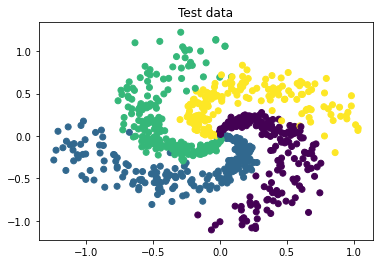

In [7]:
def shuffle_and_split_data(X, y, seed):
    # set seed for reproducibility
    torch.manual_seed(seed)
    # Number of samples
    N = X.shape[0]
    # Shuffle data
    shuffled_indices = torch.randperm(N)   # get indices to shuffle data, could use torch.randperm
    X = X[shuffled_indices]
    y = y[shuffled_indices]

    # Split data into train/test
    test_size =  int(0.2*N)   # assign test datset size using 20% of samples
    X_test = X[:test_size]
    y_test = y[:test_size]
    X_train = X[test_size:]
    y_train = y[test_size:]

    return X_test, y_test, X_train, y_train

X_test, y_test, X_train, y_train = shuffle_and_split_data(X, y, seed=0)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.title('Test data')
plt.show()

And we need to make a Pytorch data loader out of it. Data loading in PyTorch can be separated in 2 parts:
* Data must be wrapped on a Dataset parent class where the methods __getitem__ and __len__ must be overrided. Note that at this point the data is not loaded on memory. PyTorch will only load what is needed to the memory. Here `TensorDataset` does this for us directly.
* Use a Dataloader that will actually read the data in batches and put into memory. Also, the option of `num_workers > 0` allows multithreading, which prepares multiple batches in the queue to speed things up.

In [8]:
g_seed = torch.Generator()
g_seed.manual_seed(0)

batch_size = 128
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=2,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                        shuffle=True, num_workers=2,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

In [9]:
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False, device='cpu'):

    net.train()
    training_losses = []
    for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            if verbose:
                training_losses += [loss.item()]

    net.eval()
    def test(data_loader):
        correct = 0
        total = 0
        for data in data_loader:
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        return total, acc

    train_total, train_acc = test(train_loader)
    test_total, test_acc = test(test_loader)

    if verbose:
        print(f"Accuracy on the {train_total} training samples: {train_acc:0.2f}")
        print(f"Accuracy on the {test_total} testing samples: {test_acc:0.2f}")

    if training_plot:
        plt.plot(training_losses)
        plt.xlabel('Batch')
        plt.ylabel('Training loss')
        plt.show()

    return train_acc, test_acc

In [10]:
set_seed(SEED)
net = Net('ReLU()', X_train.shape[1], [128], K).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 100

_, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)

Random seed 2021 has been set.


  0%|          | 0/100 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Caskroom/miniforge/base/envs/nma/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
  File "/opt/homebrew/Caskroom/miniforge/base/envs/nma/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/nma/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/nma/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'seed_worker' on <module '__main__' (built-in)>
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'seed_worker' on <module '__main__' (built-in)>


RuntimeError: DataLoader worker (pid(s) 7013, 7014) exited unexpectedly

In [ ]:
def sample_grid(M=500, x_max=2.0):
    ii, jj = torch.meshgrid(torch.linspace(-x_max, x_max, M),
                          torch.linspace(-x_max, x_max, M))
    X_all = torch.cat([ii.unsqueeze(-1),
                     jj.unsqueeze(-1)],
                     dim=-1).view(-1, 2)
    return X_all


def plot_decision_map(X_all, y_pred, X_test, y_test,
                      M=500, x_max=2.0, eps=1e-3):
    decision_map = torch.argmax(y_pred, dim=1)

    for i in range(len(X_test)):
        indices = (X_all[:, 0] - X_test[i, 0])**2 + (X_all[:, 1] - X_test[i, 1])**2 < eps
        decision_map[indices] = (K + y_test[i]).long()

    decision_map = decision_map.view(M, M)
    plt.imshow(decision_map, extent=[-x_max, x_max, -x_max, x_max], cmap='jet')
    plt.show()

In [ ]:
X_all = sample_grid()
y_pred = net(X_all)
plot_decision_map(X_all, y_pred, X_test, y_test)